In [3]:
# basic imports 
print("Basic imports...")
import matplotlib.pyplot as plt 
from pathlib import Path 
from importlib import reload 
import time 

# Notebook imports 
from IPython.display import clear_output

# Learning imports 
print("RL imports...")
import torch 
import gymnasium as gym

# Custom imports 
print("Custom imports...") 
from RLManager import * 
import RLManager
import MissileEnv

Basic imports...
RL imports...
Custom imports...


In [4]:
def movmean(data, Nmean=50): 
    data = target_impact_lengths
    flat = np.ones(target_impact_lengths.shape)
    avg_filt = np.ones(Nmean) / Nmean
    edge_destroyer = 1 / np.convolve(flat, avg_filt, 'same')
    out = np.convolve(data, avg_filt, 'same') * edge_destroyer
    return out 

Misc Imports...
Torch imports...
Custom imports...
Finished imports.
Device: cpu


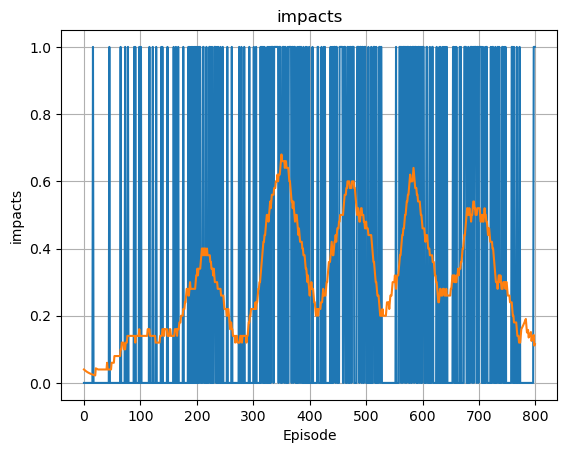

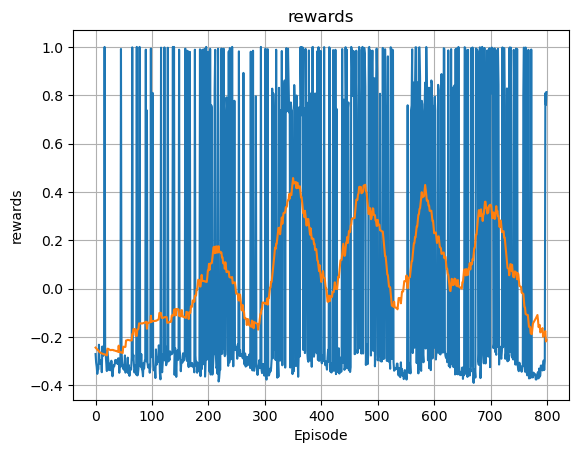

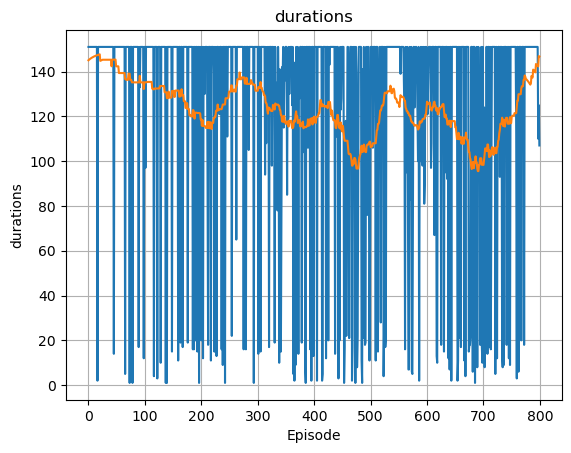

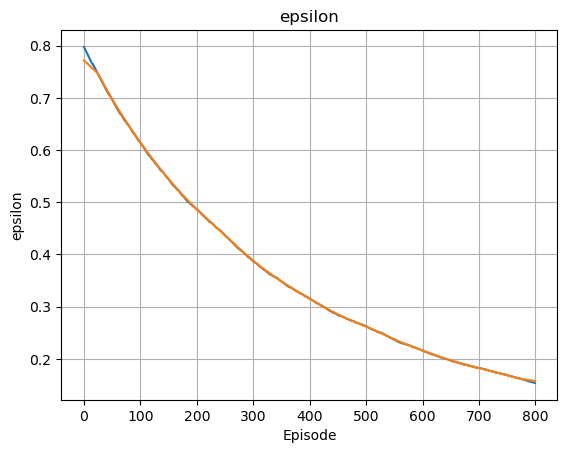

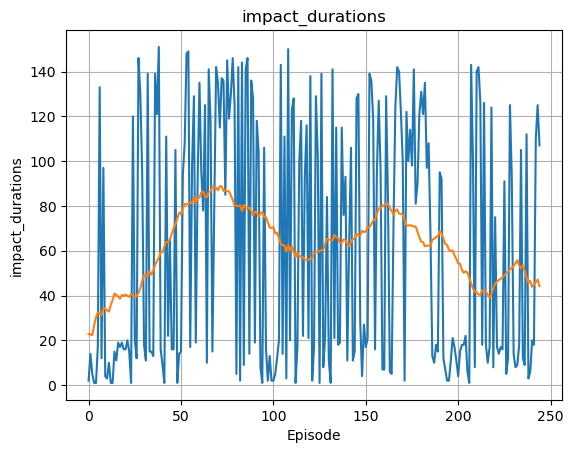

dict_keys(['durations', 'rewards', 'impacts', 'epsilon'])

In [28]:
# Plot training curves 
# def plot_training(path): 
reload(RLManager)

data = Path('Output') / 'ModelStats'
dd = torch.load(data, weights_only=False)
epp = lambda s: RLManager.episode_plot(dd[s], s)
target_impact_lengths = np.array(dd['durations'])[dd['impacts']]

epp('impacts')
plt.show()
epp('rewards')
plt.show()
epp('durations')
plt.show()
epp('epsilon')
plt.show()
RLManager.episode_plot(target_impact_lengths, 'impact_durations')
plt.show()

dd.keys()

In [29]:
# Load the model 
save_loc = Path('Output')
# save_loc = Path("Archive") / "Missile_08_1600e_dist_loss"

model = torch.load(save_loc / 'ModelTorch.pkl', weights_only=False)  # Needs access to DQN class \

# Try reloading the best checkpoint 
use_checkpoint = True
if use_checkpoint: 
    try: 
        weights = torch.load(save_loc / 'CheckpointWeights.wts', weights_only=True)
        model.load_state_dict(weights)
        print("Successfully loaded checkpoint.") 
    except Exception as e: 
        print("Loading weights failed: ") 
        print(e)

Successfully loaded checkpoint.


In [57]:
# Test the model 
reload(MissileEnv)

# Behavior vars 
pause_frames = False 

# env = gym.make("CartPole-v1", render_mode='human')
# name = 'cart' 

env = MissileEnv.MissileEnv()
env.render_mode = 'human'
env.follow_missile = True
env.move_target = True
env.training_length_frames = 10 * (1/env.dt) 
name = 'missile'

observation, info = env.reset()

# Run the model
frames_per_pause = 15
n = 500
da = (env.action_size-1)/2
actions = []
rewards = []
tx = []
ty = []
mx = []
my = []
obs = observation[np.newaxis, :]
for _ in range(n):
    print(f"Step {_}")
    # action = env.action_space.sample()
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    action = model(state).max(1).indices.view(1, 1)
    actions.append((action.cpu().numpy()[0][0]-da)/da)
    observation,reward, terminated, truncated, info = env.step(action.item())

    # Tracking 
    print(f"obs   : {observation}")
    obs = np.concat((obs, observation[np.newaxis, :]), axis=0)
    rewards.append(reward)
    tx.append(env.target.position.x)
    ty.append(env.target.position.y)
    mx.append(env.missile.position.x)
    my.append(env.missile.position.y)
    
    # Plotting 
    if pause_frames: 
        if (_+1) % frames_per_pause == 0: 
            clear_output()
            plt.plot(actions, '.-')
            plt.plot(obs[:, 4], '.-')
            plt.plot(obs[:, 2], '.-')
            plt.plot(obs[:, 3], '.-')
            plt.plot(rewards, '.-')
            plt.legend(["Action", 'distance', "v_inline", 'v_offline', 'reward'])
            plt.grid()
            plt.show()
        
            x = input("continue?")
            if x == 'quit': 
                break
    
    if terminated or truncated:
        observation, info = env.reset()
        break

Step 0
obs   : [-0.99450624 -0.10467733 -0.754716   -0.65605164  1.        ]
Step 1
obs   : [-0.99154895 -0.12973309 -0.77484109 -0.63215607  1.        ]
Step 2
obs   : [-0.98780239 -0.15571269 -0.80567613 -0.59235629  1.        ]
Step 3
obs   : [-0.9831367  -0.18287216 -0.84585539 -0.53341228  1.        ]
Step 4
obs   : [-0.9773981  -0.21140708 -0.89213239 -0.45177405  1.        ]
Step 5
obs   : [-0.9958604  -0.09089589 -0.87688573 -0.48069889  1.        ]
Step 6
obs   : [-0.99185397 -0.12738017 -0.93158626 -0.36352033  1.        ]
Step 7
obs   : [-0.9862221  -0.16542662 -0.97487466 -0.2227541   1.        ]
Step 8
obs   : [-0.99455766 -0.10418766 -0.98458766 -0.1748918   1.        ]
Step 9
obs   : [-0.99999109 -0.00422181 -0.98522619 -0.17125816  1.        ]
Step 10
obs   : [-0.99530391 -0.09679939 -0.99877492 -0.04948402  1.        ]
Step 11
obs   : [-0.99998175 -0.00604075 -0.99823417 -0.0594016   1.        ]
Step 12
obs   : [-0.99494203 -0.10045077 -0.9649829  -0.26231281  1.      

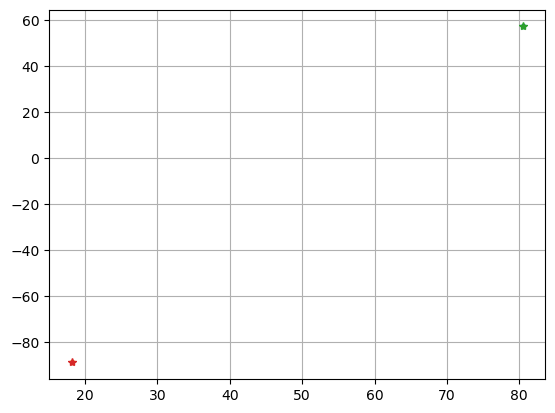

In [48]:
# Plot position over time 
plt.plot(tx, ty, '.-')
plt.plot(mx, my, '.-')
plt.plot(tx[0], ty[0], '*')
plt.plot(mx[0], my[0], '*')
plt.grid()

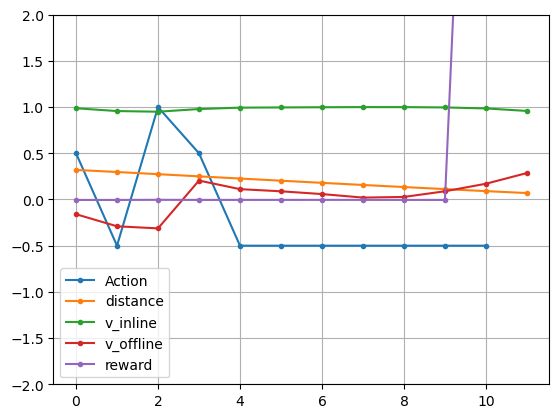

In [32]:
# Plot human readable inputs / outputs
reward_mult = 10
plt.plot(actions, '.-')
plt.plot(obs[:, 4], '.-')
plt.plot(obs[:, 2], '.-')
plt.plot(obs[:, 3], '.-')
plt.plot(np.array(rewards)*reward_mult, '.-')
plt.legend(["Action", 'distance', "v_inline", 'v_offline', 'reward'])
plt.ylim([-2, 2])
plt.grid()

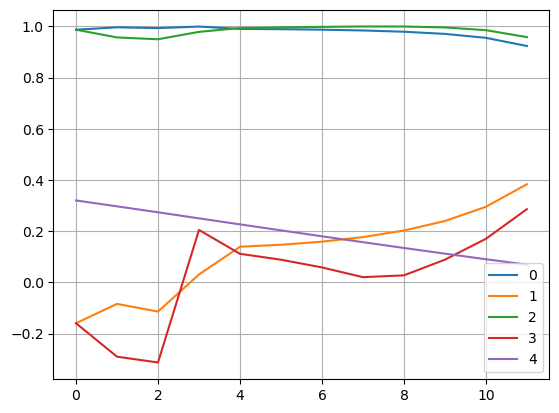

In [33]:
n = 5
plt.figure()
plt.plot(obs[:, 0:n])
plt.legend(list(range(n)))
plt.grid()

In [173]:
np.abs(observation[3])

np.float64(0.18939055053765502)

In [43]:
reward

10